In [8]:
from rosbags.rosbag2 import Reader
from rclpy.serialization import deserialize_message
from beep_interfaces.msg import MotorData
from sensor_msgs.msg import Imu

from pathlib import Path
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.ndimage import gaussian_filter1d
import math
from scipy.spatial.transform import Rotation

from traction_testing import WHEEL_RADIUS, dt, duty_profile 

Text(0, 0.5, 'Duty')

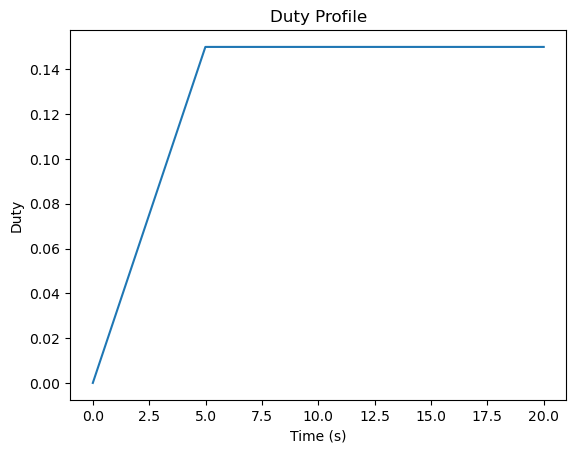

In [9]:
t = np.linspace(0, len(duty_profile) * dt, len(duty_profile))

plt.figure()
plt.plot(t, duty_profile)

plt.title("Duty Profile")
plt.xlabel("Time (s)")
plt.ylabel("Duty")


In [10]:
class TopicMeta:
    def __init__ (self, name, type):
        self.name = name
        self.type = type

topic_metas = {
    "/dev0/motor_data": TopicMeta("motor0", MotorData),
    "/dev1/motor_data": TopicMeta("motor1", MotorData),
    "/imu0/data": TopicMeta("imu", Imu)
}

def get_all_data(path):
    data = {}
    timestamps = {}
    
    #read from rosbags
    with Reader(path) as reader:
        for connection in reader.connections:
            if connection.topic in topic_metas.keys():
                print(connection.topic, connection.msgtype)
                name = topic_metas[connection.topic].name
                data[name] = []
                timestamps[name] = []

        for connection, timestamp, rawdata in reader.messages():
            if connection.topic in topic_metas:
                meta = topic_metas[connection.topic]
                msg = deserialize_message(rawdata, meta.type)
                data[meta.name].append(msg)
                timestamps[meta.name].append(timestamp)

    #turn timestamps to time
    time = timestamps
    for key, val in timestamps.items():
        time[key] = np.array(val)
        
    return data, time

def reduce_object_vector (vector, attribute):
    return np.array(list(map(lambda x: getattr(x, attribute), vector)))
    
def get_graphable_data(data, time, source, attribute="data", getTimestamps = False):
    r_time = time[source]
    if (getTimestamps==False):
        r_time = (time[source] - time[source][0]) / 1e9
        
    return reduce_object_vector(data[source], attribute), r_time

def synch_timestamps (timestamps):
    earliest = min(list(map(lambda x: x[0], timestamps)))
    times = list(map(lambda x: (x - earliest) / 1e9, timestamps))
    return times

def two_zeros_euler(quat): 
    rot = Rotation.from_quat((quat.x, quat.y, quat.z, quat.w))
    rot_euler = rot.as_euler("xyz", degrees=True)
    return rot_euler


In [23]:
from numpy import cross, eye, dot
from pyquaternion import Quaternion

def rad_to_deg(x, y, z):
    return [x * 180.0 / (2 * math.pi), y * 180.0 / (2 * math.pi), z * 180.0 / (2 * math.pi)]


def euler_from_quaternion(q):
    #rotate to center the balance point at 0
    origin = [0, 1, 0]
    theta = math.pi / 2.0 #radian
    q1 = Quaternion(axis=origin,angle=theta).rotate(q)

    sqw = q1.w * q1.w
    sqx = q1.x * q1.x
    sqy = q1.y * q1.y
    sqz = q1.z * q1.z

    unit = sqx + sqy + sqz + sqw
    test = q1.x * q1.y + q1.z * q1.w

    #heading, attitude, bank = y,z,x
    if (test > 0.499*unit): # singularity at north pole
        y = 2.0 * math.atan2(q1.x,q1.w)
        z = math.pi / 2.0
        x = 0
        return rad_to_deg(x, y, z)

    if (test < -0.499*unit): # singularity at south pole
        y = - 2.0 * math.atan2(q1.x,q1.w)
        z = - math.pi / 2.0
        x = 0
        return rad_to_deg(x, y, z)

    y = math.atan2(2.0 * q1.y * q1.w - 2 * q1.x * q1.z , sqx - sqy - sqz + sqw)
    z = math.asin(2.0 * test / unit)
    x = math.atan2(2.0 * q1.x * q1.w-2 * q1.y * q1.z , -sqx + sqy - sqz + sqw)

    return rad_to_deg([x, y, z])

In [21]:
bags = glob("../bags/*")
bags.sort()
path = Path(bags[-1])

# bag_num = "rosbag2_2024_09_13-22_42_03"
# path = glob(f"../bags/{bag_num}")[0]
print(path)
data, time = get_all_data(path)

../bags/rosbag2_2024_09_07-16_00_52
/imu0/data sensor_msgs/msg/Imu
/dev1/motor_data beep_interfaces/msg/MotorData
/dev0/motor_data beep_interfaces/msg/MotorData


In [24]:
orientation, orientation_t = get_graphable_data(data, time, "imu", "orientation")
euler_orientation = list(map(two_zeros_euler, orientation))
two_zeros_y = list(map(lambda coords: coords[1], euler_orientation))

#euler_to_quat func
euler_orientation = list(map(euler_from_quaternion, orientation))
euler_orientation_y = list(map(lambda coords: coords[1], euler_orientation))

linear_acceleration, linear_acceleration_t = get_graphable_data(data, time, "imu", "linear_acceleration")
linear_acceleration_x = list(map(lambda coords: coords.x, linear_acceleration))


fig1, ax1 = plt.subplots()
ax1.plot(orientation_t, euler_orientation_y, "r")
ax1.plot(orientation_t, two_zeros_y, "b")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Lean Angle")
ax1.set_title("Lean Angle")

TypeError: object of type 'Quaternion' has no len()